In [1]:
# Author : Evangelos Papoutsellis
# Contact : http://epapoutsellis.github.io/

In [2]:
# Import libraries
from cil.framework import  AcquisitionGeometry, VectorData
from cil.optimisation.functions import L2NormSquared, ZeroFunction, LeastSquares
from cil.optimisation.operators import MatrixOperator
from cil.optimisation.algorithms import FISTA, ISTA
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D
from cil.utilities import dataexample
from cil.plugins.astra.utilities import convert_geometry_to_astra
from cil.optimisation.functions import TotalVariation
from cil.plugins import TomoPhantom

import matplotlib.pyplot as plt

import cvxpy
import astra

import numpy as np

/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/utilities/display.py:358: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


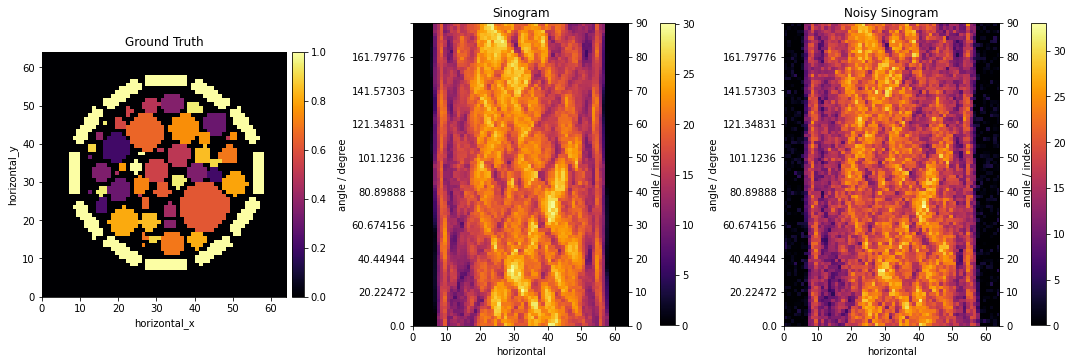

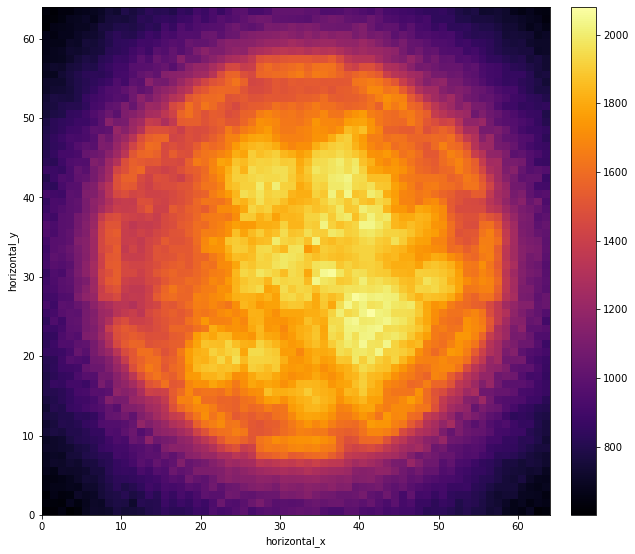

In [3]:
# Detectors
N = 64
detectors =  N

# Angles
angles = np.linspace(0,180,90, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors)
# Get image geometry
ig = ag.get_ImageGeometry()

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'cpu')

# Get phantom
# phantom = dataexample.SIMPLE_PHANTOM_2D.get(size=(N, N))
phantom = TomoPhantom.get_ImageData(12, ig)

# Create an acquisition data
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 2.
gaussian_mean = 0

np.random.seed(10)

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0
# noisy_sino.fill(sino)

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], 
       title = ['Ground Truth','Sinogram','Noisy Sinogram'], 
       num_cols=3, cmap = 'inferno')

show2D(A.adjoint(noisy_sino), cmap="inferno")

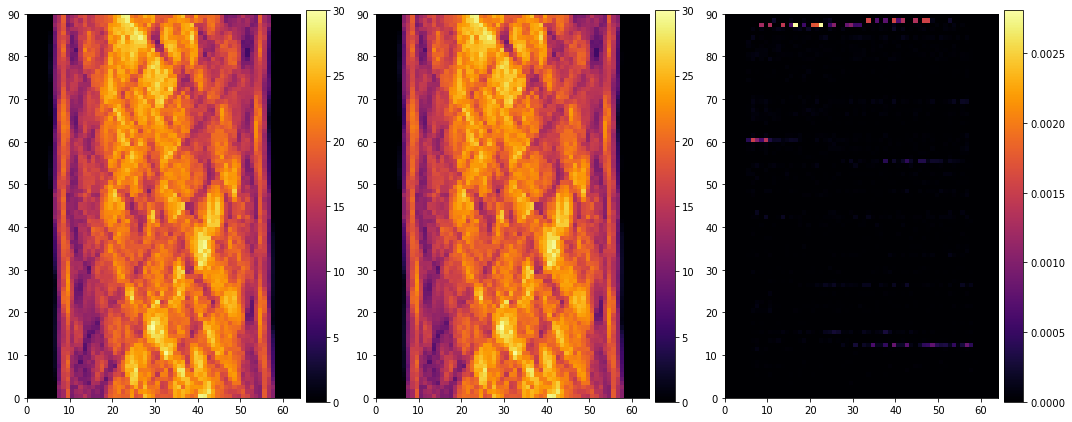

In [4]:
# convert to astra geometries
ig_astra, ag_astra = convert_geometry_to_astra(ig, ag)

# projection id
proj_id = astra.create_projector('line', ag_astra, ig_astra)

# matrix id
matrix_id = astra.projector.matrix(proj_id)

# Get the projection matrix as a Scipy sparse matrix.
W = astra.matrix.get(matrix_id)

sino_astra = (W*phantom.array.flatten()).reshape((len(ag.angles), N))

#show
show2D([sino_astra, sino.array, np.abs(sino.array-sino_astra)], num_cols=3, cmap="inferno")

# print("Norm of A_cil = {}".format(A.norm()))

mat_cil = MatrixOperator(W.T*W)

# print("Norm of astra mat = {}".format(np.sqrt(mat_cil.norm())))



In [5]:
alpha = 50.

In [6]:
N, M = ig.shape
u_cvx = cvxpy.Variable(N*M)
fidelity = cvxpy.sum_squares(W@u_cvx.flatten() - noisy_sino.array.flatten())
constraints = [u_cvx>=0]

regulariser = (alpha/ig.voxel_size_x) * cvxpy.tv(cvxpy.reshape(u_cvx, (N,M))) 
obj =  cvxpy.Minimize( fidelity + regulariser)
prob = cvxpy.Problem(obj, constraints)

res = prob.solve(solver = cvxpy.MOSEK, verbose = True)
# res = prob.solve(solver = SCS, verbose = True, eps=1e-3)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) May 15 04:22:11 PM: Your problem has 4096 variables, 1 constraints, and 0 parameters.
(CVXPY) May 15 04:22:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 15 04:22:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 15 04:22:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 15 04:22:11 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 15 04:22:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

### ISTA algorithm

In [7]:
initial = ig.allocate()

f = LeastSquares(A, noisy_sino)
g = alpha * TotalVariation(max_iteration=50, tolerance=0, lower=0)

ista = ISTA(initial = initial, f = f, g = g, max_iteration=500, update_objective_interval=1)  
ista.run(verbose=0)

### FISTA algorithm

In [8]:
fista = FISTA(initial = initial, f = f, g = g, max_iteration=500, update_objective_interval=1)  
fista.run(verbose=0)

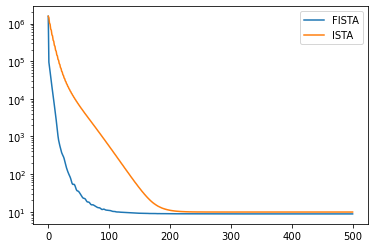

In [9]:
plt.figure()
plt.semilogy(np.abs(fista.objective - obj.value), label="FISTA")
plt.semilogy(np.abs(ista.objective - obj.value), label="ISTA")
plt.legend()
plt.show()

Objective value of CVXpy = 44857.07859587796
Objective value of ISTA = 44866.927001953125
Objective value of FISTA = 44865.864501953125


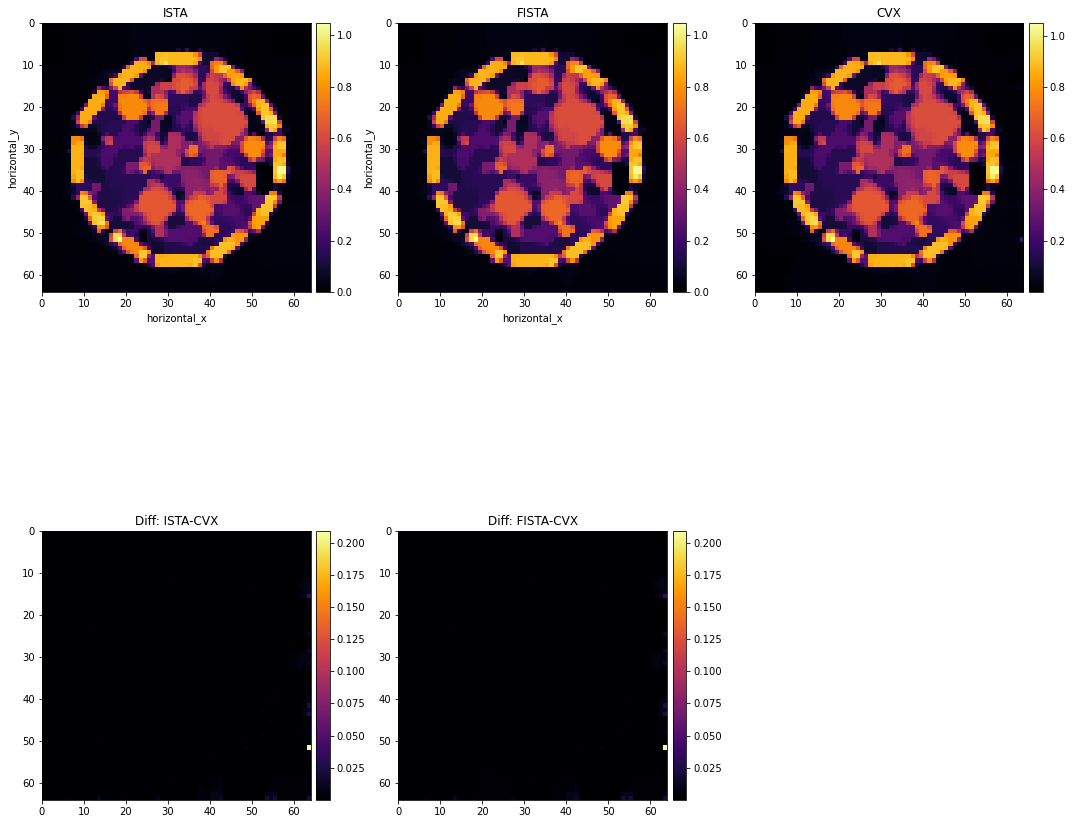

In [10]:
print("Objective value of CVXpy = {}".format(obj.value))
print("Objective value of ISTA = {}".format(ista.objective[-1]))
print("Objective value of FISTA = {}".format(fista.objective[-1]))

# assert ista/fista vs cvxpy
cvx_sol = u_cvx.value.reshape(N,N)

show2D([ista.solution, fista.solution, cvx_sol, 
        np.abs(ista.solution.array-cvx_sol), np.abs(fista.solution.array-cvx_sol)], 
       cmap="inferno", origin="upper",
      num_cols=3, title=['ISTA','FISTA','CVX', 
                          'Diff: ISTA-CVX', 'Diff: FISTA-CVX'])

### Solve liner system Ax=b (LeastSquares) with ISTA, FISTA, CVX


In [11]:
np.random.seed(10)
n = 100
m = 1000

A = np.random.uniform(0,1, (m, n)).astype('float32')
b = (A.dot(np.random.randn(n)) + 0.1*np.random.randn(m)).astype('float32')


In [12]:
Aop = MatrixOperator(A)
bop = VectorData(b) 

f = LeastSquares(Aop, b=bop,c=0.5)
g = ZeroFunction()
ig = Aop.domain
initial = ig.allocate()

ista = ISTA(initial = initial, f = f, g = g, max_iteration=1000, update_objective_interval=1)  
ista.run(verbose=0)

fista = FISTA(initial = initial, f = f, g = g, max_iteration=1000, update_objective_interval=1)  
fista.run(verbose=0)

In [13]:
z = cvxpy.Variable(n)
objective = cvxpy.Minimize(0.5 * cvxpy.sum_squares(A @ z - b))
constraint = []
p = cvxpy.Problem(objective, constraint)
p.solve(verbose=True, solver=cvxpy.MOSEK)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) May 15 04:23:20 PM: Your problem has 100 variables, 0 constraints, and 0 parameters.
(CVXPY) May 15 04:23:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 15 04:23:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 15 04:23:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 15 04:23:20 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 15 04:23:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

4.365863010698794

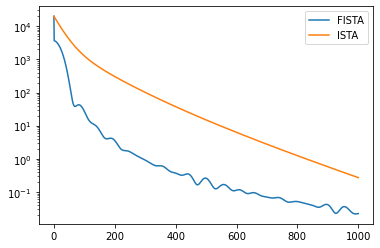

Objective value of CVXpy = 4.365863010698794
Objective value of ISTA = 4.6376729011535645
Objective value of FISTA = 4.3882551193237305


In [14]:
plt.figure()
plt.semilogy(np.abs(fista.objective - p.value), label="FISTA")
plt.semilogy(np.abs(ista.objective - p.value), label="ISTA")
plt.legend()
plt.show()

print("Objective value of CVXpy = {}".format(p.value))
print("Objective value of ISTA = {}".format(ista.objective[-1]))
print("Objective value of FISTA = {}".format(fista.objective[-1]))